# NNTI Assignment 3

Name 1: Md Mobashir Rahman <br>
Student id 1: 7059086 <br>
Email 1: mdra00001@stud.uni-saarland.de <br>

Name 2: Ratnadeep Chakraborty <br>
Student id 2: 7022859 <br>
Email 2: rach00002@stud.uni-saarland.de <br>

Name 3: <br>
Student id 3:  <br>
Email 3: <br>

**Instructions:** Read each question carefully. <br/>
Make sure you appropriately comment your code wherever required. Your final submission should contain the completed Notebook and the respective  files for any additional exercises necessary. There is no need to resubmit the data files should they be provided separately. <br>


Upload the zipped folder on CMS. Please follow the naming convention of **Name1_id1_Name2_id2_Name3_id3.zip **. Only one member of the group should make the submisssion.


In [1]:
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

### Data setup: (Provided for you)
We are using the MNIST dataset from [Pytorch](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html). For the sake of simplicity, we are only using only the first 2000 samples from the test set. Here, we have normalized the images to the range [0, 1], then reshaped each image to a tensor vector of size 784 and stack them together to get an array of 2000x784.

In [2]:
# Load MNIST data
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Extract the first 2000 samples
data = mnist_data.data[:2000].float()
labels = mnist_data.targets[:2000]

# Normalize the data to [0, 1]
data /= 255.0

# Reshape the data
n, d = data.size(0), data.size(1) * data.size(2)  # n = 2000, d = 784
X = data.view(n, d)

### a. Eigendecomposition [1 point]


i.   Complete the function `eigen_decomp()`. Take care to:

- Center the input data `X` by subtracting the mean of each feature.
- Calculate the covariance matrix and performs eigendecomposition to obtain eigenvalues and eigenvectors.
- Compute the cumulative variance explained by each component and return it.


ii.   Plot the cumulative explained variance against the number of principal components.

(i) Completing the function eigne_decomp()

In [3]:
def eigen_decomp(X):
    """
    Performs eigendecomposition on the covariance matrix of the input data `X`.

    Args:
        X (torch.Tensor): A 2D tensor where rows represent samples and columns represent features.

    Returns:
        tuple: A tuple containing:
            - eigvals (torch.Tensor): Eigenvalues of the covariance matrix, representing variance explained by each principal component.
            - eigvecs (torch.Tensor): Eigenvectors of the covariance matrix, each representing a principal component direction.
            - cumulative_variance_explained (np.ndarray): Cumulative variance explained by each principal component, as a numpy array.
    """
    # Center the data
    X_centered = X - torch.mean(X, dim=0)

    # Compute covariance matrix
    covariance_matrix = torch.mm(X_centered.T, X_centered) / (X_centered.size(0) - 1)

    # Perform eigendecomposition using symmetric eigendecomposition
    eigvals, eigvecs = torch.linalg.eigh(covariance_matrix)

    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = torch.argsort(eigvals, descending=True)
    eigvals = eigvals[sorted_indices]
    eigvecs = eigvecs[:, sorted_indices]

    # Compute cumulative variance explained
    cumulative_variance = torch.cumsum(eigvals, dim=0)
    total_variance = torch.sum(eigvals)
    cumulative_variance_explained = (cumulative_variance / total_variance).numpy()

    return eigvals, eigvecs, cumulative_variance_explained

(ii) Plotting Cumulative Explained Variance

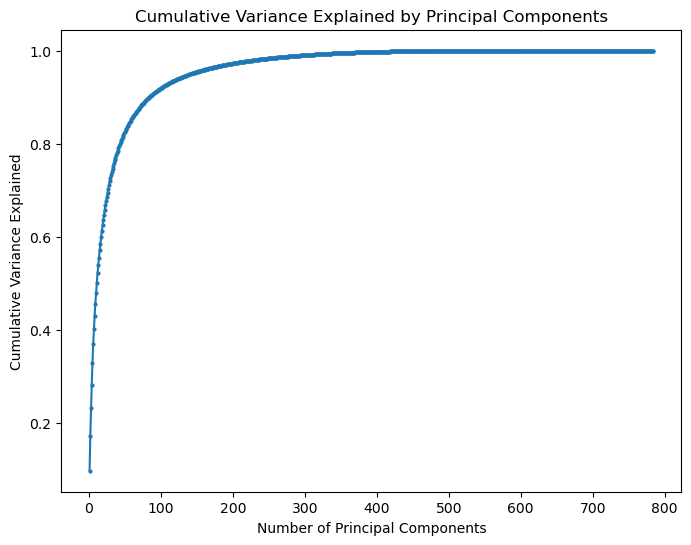

In [4]:
eigvals, eigvecs, cumulative_variance_explained = eigen_decomp(X)

# Plot the cumulative variance against the principal components

# Define the number of principal components
principal_components = np.arange(1, len(cumulative_variance_explained) + 1)

# Plot cumulative variance explained with smaller dots
plt.figure(figsize=(8, 6))
plt.plot(principal_components, cumulative_variance_explained, marker='o', markersize=2)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by Principal Components')
plt.grid(False)
plt.show()

### Answer the below question: [0.25 points]

Q: What do you think happens when we reduce the number of principal components $p$?

### Creating a cumulative variance plot with incrementally decreasing number of principal components

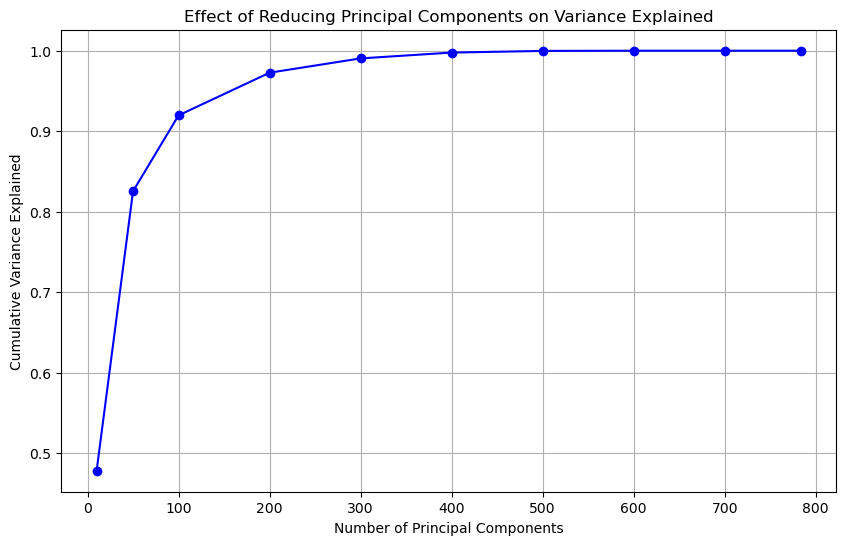

In [5]:
# Define the number of principal components to evaluate
components_to_evaluate = [10, 50, 100, 200, 300, 400, 500, 600, 700, 784] 

# Calculate the cumulative variance explained for each number of components
cumulative_variance = [cumulative_variance_explained[p-1] for p in components_to_evaluate]

# Plot the cumulative variance explained
plt.figure(figsize=(10, 6))
plt.plot(components_to_evaluate, cumulative_variance, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Effect of Reducing Principal Components on Variance Explained')
plt.grid(True)
plt.show()

A: Reducing the number of principal components ( p ) decreases the dimensionality of the data representation. This means that less of the total variance in the data is captured by the retained components. As a result, some information is lost, potentially affecting the performance of any models or analyses that use this reduced data. While reducing ( p ) can simplify the model and help prevent overfitting, it may also lead to a loss of important underlying patterns in the data.

There is a threshold where the maximum variance is explained but increasing principal component beyond that point does not increase the cumulative variance significantly anymore. (The curve becomes almost flattened). It would be waste of computational resource to compute principal component beyond this point.

That point for the above graph is: 400 (by looking at the plot.)

### b. PCA [1 point]

Complete the function `pca_reconstruction_error()`. It should:
- Center the input data `X` by subtracting the mean of each feature (again).
- Projects `X` onto the top `p` principal components, reconstructs it.
- Compute the normalized reconstruction error in terms of the Frobenius norm, i.e. $e_{p} = \frac{\|x - \hat{x}_p\|_{F}}{\|x\|_{F}}$, where $x$ denotes the input matrix and $\hat{x}_p$ denotes the recovered matrix associated to each $p$.


In [6]:
import torch

def pca_reconstruction_error(X, p, eigvecs):
    """
    Calculates the PCA reconstruction error for the given data `X` using the top `p` principal components.

    Args:
        X (torch.Tensor): A 2D tensor where rows represent samples and columns represent features.
        p (int): The number of principal components to use for reconstruction.
        eigvecs (torch.Tensor): Eigenvectors obtained from PCA, with each column representing a principal component direction.

    Returns:
        tuple: A tuple containing:
            - error (float): The normalized Frobenius norm of the difference between `X` and its PCA reconstruction, representing the reconstruction error.
            - X_reconstructed (torch.Tensor): The reconstructed data using `p` principal components.
    """
    # Center the data
    X_centered = X - X.mean(dim=0)
    
    # Select the top p eigenvectors
    eigvecs_p = eigvecs[:, :p]
    
    # Project the data onto the top p principal components
    projection = X_centered @ eigvecs_p
    
    # Reconstruct the data from the projection
    X_reconstructed = projection @ eigvecs_p.T + X.mean(dim=0)
    
    # Compute the Frobenius norm of the reconstruction error
    error = torch.norm(X - X_reconstructed, p='fro') / torch.norm(X, p='fro')
    
    return error.item(), X_reconstructed

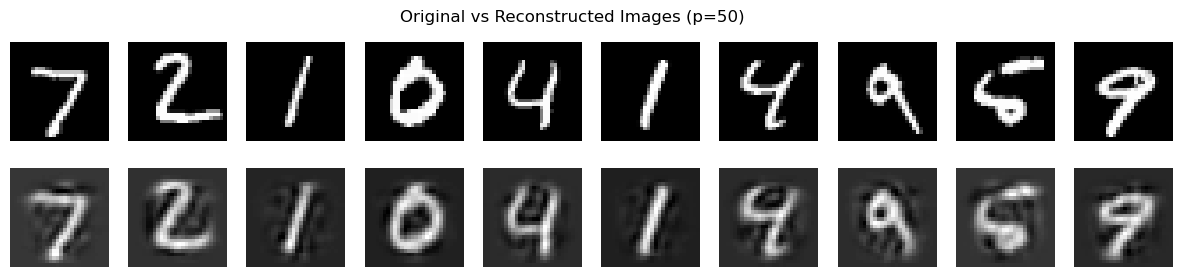

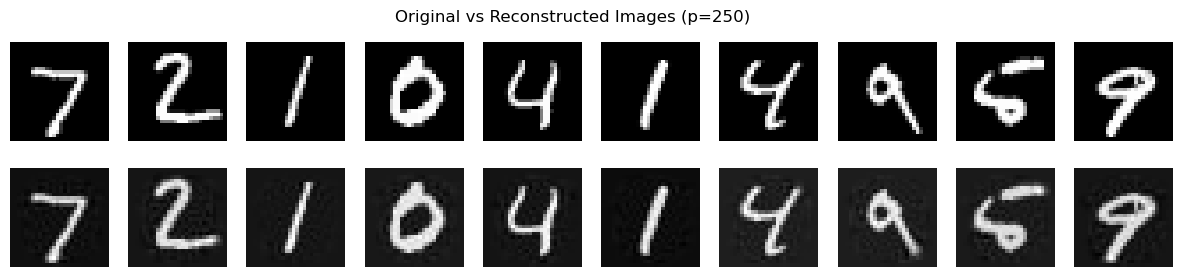

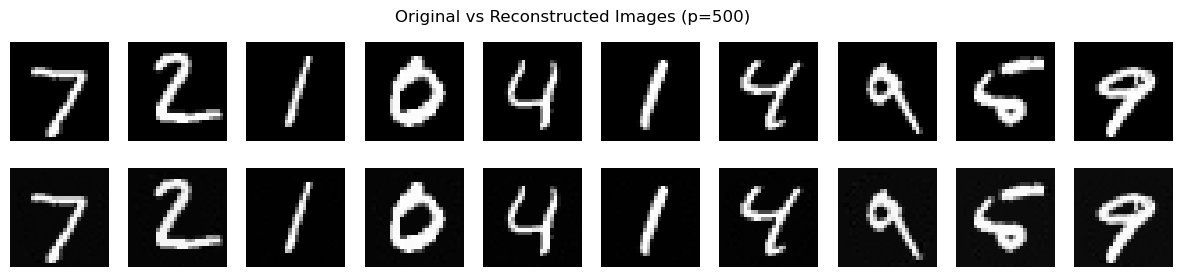

Frobenius Norm Errors: [0.32762885093688965, 0.10058772563934326, 0.012200935743749142]


In [7]:
### Driver code for the previousky defined functions
frobenius_norm = []

# Evaluate for p = 50, 250, 500
for p in [50, 250, 500]:
    error, X_reconstructed = pca_reconstruction_error(X, p, eigvecs)
    frobenius_norm.append(error)

    # Visualize some original and reconstructed images
    fig, axes = plt.subplots(2, 10, figsize=(15, 3))
    for i in range(10):
        axes[0, i].imshow(X[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
    plt.suptitle(f'Original vs Reconstructed Images (p={p})')
    plt.show()

print(f"Frobenius Norm Errors: {frobenius_norm}")

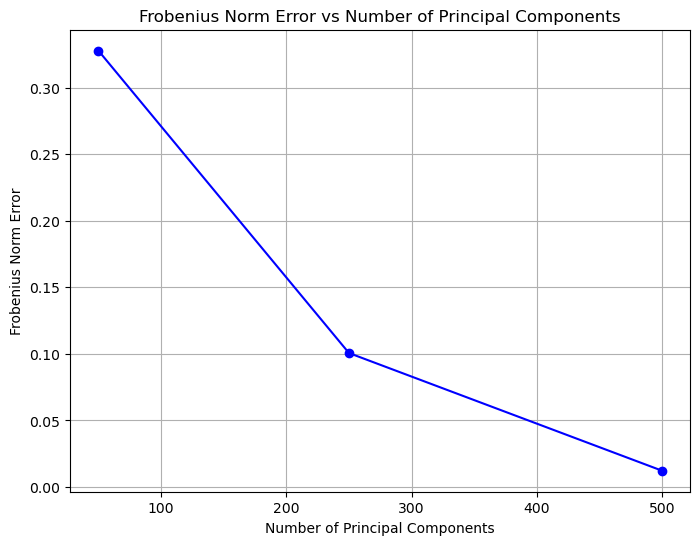

In [8]:

components = [50, 250, 500]

# Plot the Frobenius norm errors
plt.figure(figsize=(8, 6))
plt.plot(components, frobenius_norm, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Frobenius Norm Error')
plt.title('Frobenius Norm Error vs Number of Principal Components')
plt.grid(True)
plt.show()

Observation: with increasing number of principal components, Frobenius norm error reduces, there might be a point where the curve might be visually flattened in the plot.

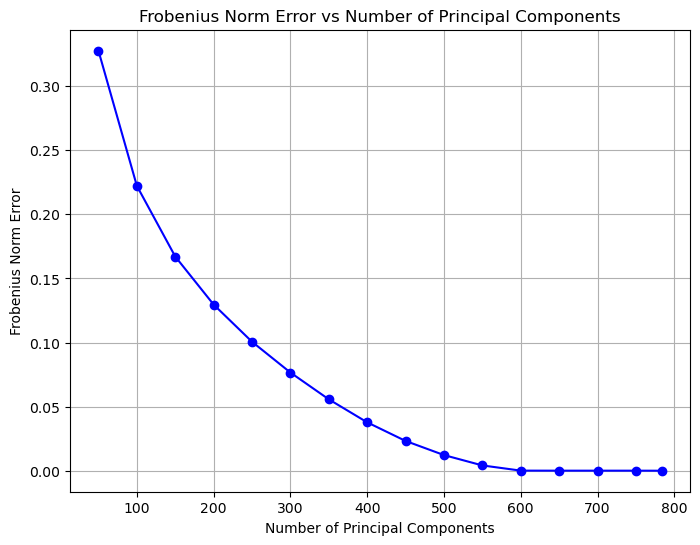

In [9]:
# Define the new set of principal components to evaluate
new_components = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 784]

# Initialize a new list to store the Frobenius norm errors
new_frobenius_norm = []

# Evaluate for the new set of principal components
for p in new_components:
    error, X_reconstructed = pca_reconstruction_error(X, p, eigvecs)
    new_frobenius_norm.append(error)
    
plt.figure(figsize=(8, 6))
plt.plot(new_components, new_frobenius_norm, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Frobenius Norm Error')
plt.title('Frobenius Norm Error vs Number of Principal Components')
plt.grid(True)
plt.show()

At point 600 where the Frobenius Norm Error is almost flattened (almost 0).

### c. Noisy Data Generation [1.5 points]

i.   Complete the function `mnist_noised()` to generate noisy versions of the mnist data.

ii.   Visualize the noisy images and compare them with their corresponding original images.

iii.   Plot the cumulative explained variance of the **noisy data** along with the **original data** versus the number of components.

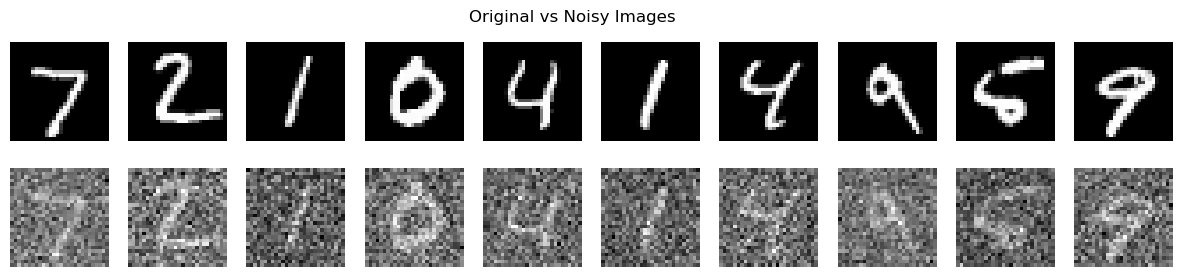

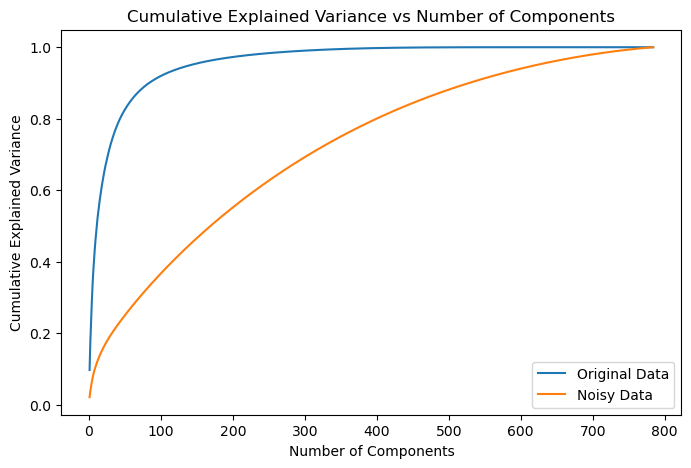

In [10]:
def mnist_noised(X, noise_var=0.25):
    """
    Adds Gaussian noise to the input data `X`.

    Args:
        X (torch.Tensor): A 2D tensor where rows represent samples and columns represent features (e.g., flattened images).
        noise_var (float, optional): The variance of the Gaussian noise to be added. Default is 0.25.

    Returns:
        torch.Tensor: A tensor with Gaussian noise added to each element of `X`.
    """
    noise = torch.randn_like(X) * noise_var ** 0.5
    return X + noise

# Add Gaussian noise to the data
noisy_data = mnist_noised(X)

# Plot some original and noisy images
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    axes[0, i].imshow(X[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(noisy_data[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
plt.suptitle('Original vs Noisy Images')
plt.show()

# Compute eigen decomposition for the noisy data
eigvals_noisy, eigvecs_noisy, cumulative_variance_explained_noisy = eigen_decomp(noisy_data)

# Plot the cumulative variance for noisy data and original data
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(cumulative_variance_explained) + 1), cumulative_variance_explained, label='Original Data')
plt.plot(np.arange(1, len(cumulative_variance_explained_noisy) + 1), cumulative_variance_explained_noisy, label='Noisy Data')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.legend()
plt.show()

Observation: Despite the added noise, some of the digits in the noisy images are still recognizable to a human eye, although with difficulty. For example, digits with simpler structures like "1" or "7" may remain somewhat discernible, whereas more complex shapes like "9" and "5" become harder to identify.

### Answer the below question: [0.25 points]

Q: How do the 2 plots compare? Are they similar?

No, the plots are not similar. The cumulative variance explained by the principal components is lower for the noisy data compared to the original data. This is expected because the noise in the data introduces additional variability that is not captured by the principal components, leading to a lower cumulative variance explained.

### d. Image Denoising [1 point]



i.   Complete the function `pca_reconstruction_noisy()`. It should:
- Add Gaussian noise of a specified variance ($\sigma^{2}$) to the original data.
- Compute the eigen decomposition on the noisy data, retaining only the top `p` principal components.
- Calculate the reconstruction error to quantify the quality of denoising.

ii. Plot the denoised images agianst the noisy data for visual comparison.



In [11]:
def pca_reconstruction_noisy(X, noise_var=0.05, p=100):
    """
    Adds Gaussian noise to input data `X`, performs PCA-based dimensionality reduction,
    and reconstructs the denoised images using the top `p` principal components.

    Args:
        X (torch.Tensor): A 2D tensor where rows represent samples and columns represent features (e.g., flattened images).
        noise_var (float, optional): Variance of the Gaussian noise to be added to `X`. Default is 0.05.
        p (int, optional): Number of principal components to retain for PCA-based reconstruction. Default is 100.

    Returns:
        tuple: A tuple containing:
            - error (float): The normalized reconstruction error after applying PCA to the noisy data.
            - X_reconstructed (torch.Tensor): A 2D tensor of reconstructed data using the top `p` components, representing the denoised images.
    """
    # Add Gaussian noise to X
    noise = torch.randn_like(X) * noise_var ** 0.5
    X_noisy = X + noise
    
    # Compute eigen decomposition on the noisy data
    eigvals_noisy, eigvecs_noisy, _ = eigen_decomp(X_noisy)
    
    # Select the top p eigenvectors
    eigvecs_p = eigvecs_noisy[:, :p]
    
    # Center the noisy data
    X_noisy_mean = X_noisy.mean(dim=0)
    X_noisy_centered = X_noisy - X_noisy_mean
    
    # Project the centered noisy data onto the top p principal components
    projection = X_noisy_centered @ eigvecs_p
    
    # Reconstruct the data
    X_reconstructed = projection @ eigvecs_p.T + X_noisy_mean
    
    # Compute the reconstruction error between original data and reconstructed data
    error = torch.norm(X - X_reconstructed, p='fro') / torch.norm(X, p='fro')
    
    return error.item(), X_reconstructed

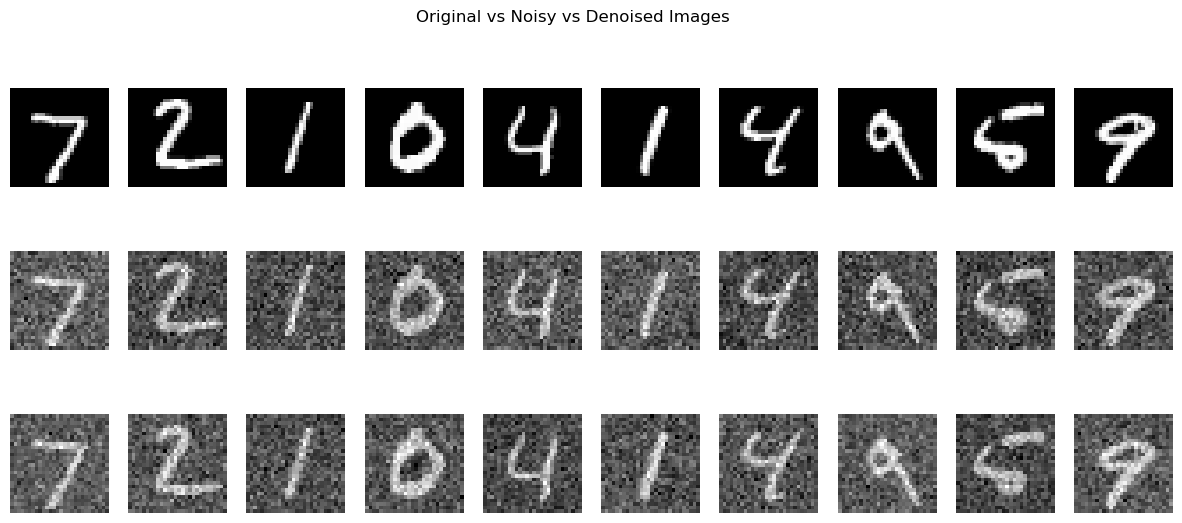

In [12]:
# Set noise variance and number of principal components
noise_var = 0.05
p = 500

# Generate noisy data
X_noisy = mnist_noised(X, noise_var=noise_var)

# Perform PCA reconstruction on noisy data
error, X_denoised = pca_reconstruction_noisy(X, noise_var=noise_var, p=p)

# Plot original, noisy, and denoised images
fig, axes = plt.subplots(3, 10, figsize=(15, 6))

for i in range(10):
    # Original images
    axes[0, i].imshow(X[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel('Original', fontsize=12)
    
    # Noisy images
    axes[1, i].imshow(X_noisy[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel('Noisy', fontsize=12)
    
    # Denoised images
    axes[2, i].imshow(X_denoised[i].reshape(28, 28), cmap='gray')
    axes[2, i].axis('off')
    if i == 0:
        axes[2, i].set_ylabel('Denoised', fontsize=12)

plt.suptitle('Original vs Noisy vs Denoised Images')
plt.show()

Observation:
The original images are clean, without any distortions or noise.
The second row is the the same set of original digits with added noise, which introduces random pixels and distorts the clarity of each digit. They are less legible.
The third row shows the noisy images after applying a denoising technique, which attempts to remove the noise while preserving the underlying structure of each digit
With p=500, the denoised images look indistinguishable from the noised images in human visual inspection. But these images still retain some residual artifacts from the noise, and different from the original image.